In [ ]:
# settings.py content
inputFile = "music"  # Name of the file to import

In [ ]:
outputFile = "music8d"      # Name of the file to export
timeLtoR = 1000             # Time taken for audio to move left -> right in ms
jumpPercentage = 5          # % of dist b/w L-R to jump at a time
panBoundary = 100           # % of dist from center that audio source can go
volumeMultiplier = 6        # Max volume DB increase at edges
speedMultiplier = 0.92      # Slowdown audio; 1.0=original, 0.5=half speed

In [ ]:
pip install pydub

In [ ]:
pip install pedalboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.7 MB/s eta 0:00:00


In [ ]:
from os.path import isfile
from pydub import AudioSegment
import soundfile as sf
from pedalboard import Pedalboard, Reverb
from os import remove as removeFile
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import numpy as np
import matplotlib.patches as patches
import librosa

In [ ]:
# loadSound.py content
def loadSound(inputFile):
    if isfile(inputFile + ".mp3"):
        return AudioSegment.from_mp3(inputFile + ".mp3")
    elif isfile(inputFile + ".wav"):
        return AudioSegment.from_wav(inputFile + ".wav")
    else:
        print("Source music file not found!")
        exit()

# effect8d.py content
def panArray():
    piecesCtoR = panBoundary / jumpPercentage
    piecesLtoR = piecesCtoR * 2
    pieceTime = int(timeLtoR / piecesLtoR)
    pan = []
    left = -panBoundary
    while left <= panBoundary:
        pan.append(left)
        left += jumpPercentage
    pan = [x / 100 for x in pan]
    return pan, pieceTime

def effect8d(sound):
    pan, pieceTime = panArray()
    sound8d = sound[0]
    panIndex = 0
    iteratePanArrayForward = True
    for time in range(0, len(sound) - pieceTime, pieceTime):
        piece = sound[time : time + pieceTime]
        if panIndex == 0:
            iteratePanArrayForward = True
        if panIndex == len(pan) - 1:
            iteratePanArrayForward = False
        volAdjust = volumeMultiplier - (abs(pan[panIndex]) / (panBoundary / 100) * volumeMultiplier)
        piece -= volAdjust
        pannedPiece = piece.pan(pan[panIndex])
        if iteratePanArrayForward:
            panIndex += 1
        else:
            panIndex -= 1
        sound8d = sound8d + pannedPiece
    return sound8d

# slow.py content
def effectSlowedDown(sound):
    soundSlowedDown = sound._spawn(
        sound.raw_data,
        overrides={"frame_rate": int(sound.frame_rate * speedMultiplier)},
    )
    soundSlowedDown.set_frame_rate(sound.frame_rate)
    return soundSlowedDown

# reverb.py content
def tempAudioFile(sound):
    with open(outputFile + ".wav", "wb") as out_f:
        sound.export(out_f, format="wav")
    audio, sampleRate = sf.read(outputFile + ".wav")
    return audio, sampleRate

def effectReverb(sound):
    sound, sampleRate = tempAudioFile(sound)
    addReverb = Pedalboard([Reverb(room_size=0.8, damping=1, width=0.5, wet_level=0.3, dry_level=0.8)])
    reverbedSound = addReverb(sound, sample_rate=sampleRate)
    return reverbedSound, sampleRate

# saveSound.py content
def saveSound(sound, sampleRate):
    with sf.SoundFile(outputFile + ".wav", "w", samplerate=sampleRate, channels=sound.shape[1]) as f:
        f.write(sound)
    AudioSegment.from_wav(outputFile + ".wav").export(outputFile + ".mp3", format="mp3")
    removeFile(outputFile + ".wav")

In [ ]:
# main.py content
sound = loadSound(inputFile)
sound8d = effect8d(sound)
sound8dAndSlowedDown = effectSlowedDown(sound8d)
sound8dSlowedDownReverbed, soundSampleRate = effectReverb(sound8dAndSlowedDown)
saveSound(sound8dSlowedDownReverbed, soundSampleRate)
# saveSound(sound8d, soundSampleRate)
print("8d + slow + reverb effect added successfully!")

8d + slow + reverb effect added successfully!


In [ ]:
## DON'T COPY THIS but leave it here!!!

# # Function to plot waveform and spectrogram
# def plot_waveform_spectrogram(sound, title):
#     # Extract data and sample rate from sound
#     data = np.array(sound.get_array_of_samples())
#     sample_rate = sound.frame_rate

#     # Plot waveform
#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(np.arange(len(data)) / sample_rate, data)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.title('Waveform')

#     # Plot spectrogram
#     plt.subplot(1, 2, 2)
#     plt.specgram(data, Fs=sample_rate)
#     plt.ylabel('Frequency (Hz)')
#     plt.xlabel('Time (s)')
#     plt.title('Spectrogram')

#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# Load regular music
regular_music = loadSound("music")
# Plot regular music waveform and spectrogram
# plot_waveform_spectrogram(regular_music, "Regular Music")

# Load 8D music
music8d = loadSound("music8d")
# Plot 8D music waveform and spectrogram
# plot_waveform_spectrogram(music8d, "8D Music")

In [ ]:
# Function to plot selected portions of waveforms
def plot_selected_portions(sound1, sound2, start_time, end_time):
    # Extract data and sample rate from sounds
    data1 = np.array(sound1.get_array_of_samples())
    data2 = np.array(sound2.get_array_of_samples())
    sample_rate = sound1.frame_rate

    # Determine start and end indices for selected portions
    start_index = int(start_time * sample_rate)
    end_index = int(end_time * sample_rate)

    # Plot selected portions of waveforms
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(start_index, end_index) / sample_rate, data2[start_index:end_index], label='8D Music', color='red')
    plt.plot(np.arange(start_index, end_index) / sample_rate, data1[start_index:end_index], label='Regular Music', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Comparison of Regular and 8D Music')
    plt.legend()
    plt.savefig('waveform.png')  # Or use .jpg, .pdf, etc.
    plt.show()

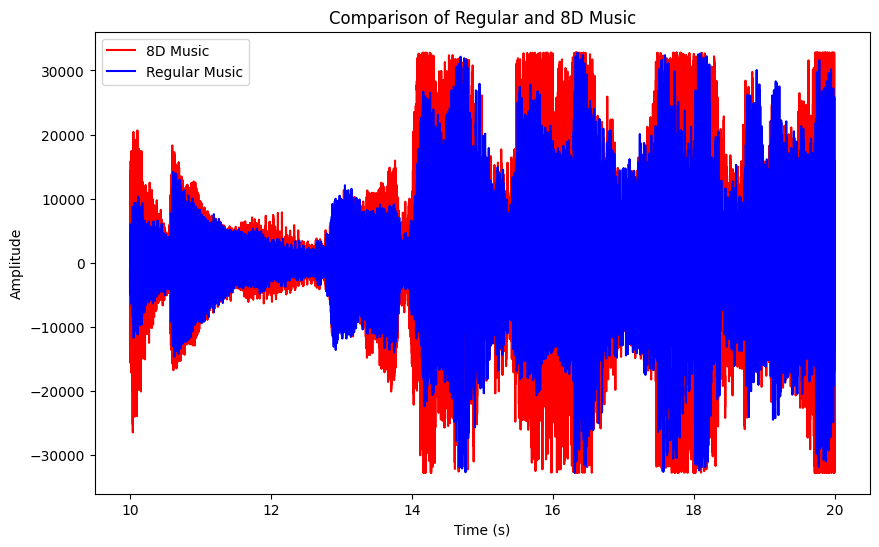

In [ ]:
# Define start and end time of the portion to plot (in seconds)
start_time = 10
end_time = 20

# Plot selected portions of waveforms
plot_selected_portions(regular_music, music8d, start_time, end_time)

In [ ]:
# Function to plot frequency spectrum and energy envelope
def plot_spectrum_and_envelope(sound1, sound2, title):
    # Extract data and sample rate from sounds
    data1 = np.array(sound1.get_array_of_samples())
    data2 = np.array(sound2.get_array_of_samples())
    sample_rate = sound1.frame_rate

    # Calculate frequency spectrum and energy envelope
    frequencies1, spectrum1 = plt.psd(data1, Fs=sample_rate)
    envelope1 = np.abs(data1)
    frequencies2, spectrum2 = plt.psd(data2, Fs=sample_rate)
    envelope2 = np.abs(data2)

    # Plot frequency spectrum and energy envelope
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(frequencies1, 10 * np.log10(spectrum1), label='Regular Music', color='blue')
    plt.plot(frequencies2, 10 * np.log10(spectrum2), label='8D Music', color='red')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title('Frequency Spectrum Comparison')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(data2)) / sample_rate, envelope2, label='8D Music', color='red')
    plt.plot(np.arange(len(data1)) / sample_rate, envelope1, label='Regular Music', color='blue')

    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.title('Energy Envelope Comparison')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

<ipython-input-14-5fa25cd47043>:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies1, 10 * np.log10(spectrum1), label='Regular Music', color='blue')
<ipython-input-14-5fa25cd47043>:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies2, 10 * np.log10(spectrum2), label='8D Music', color='red')
<ipython-input-14-5fa25cd47043>:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


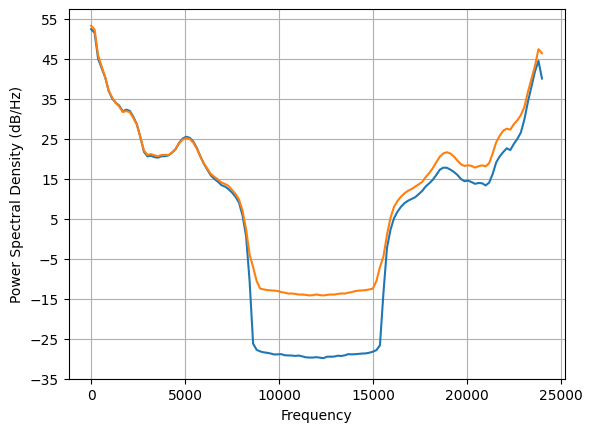

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


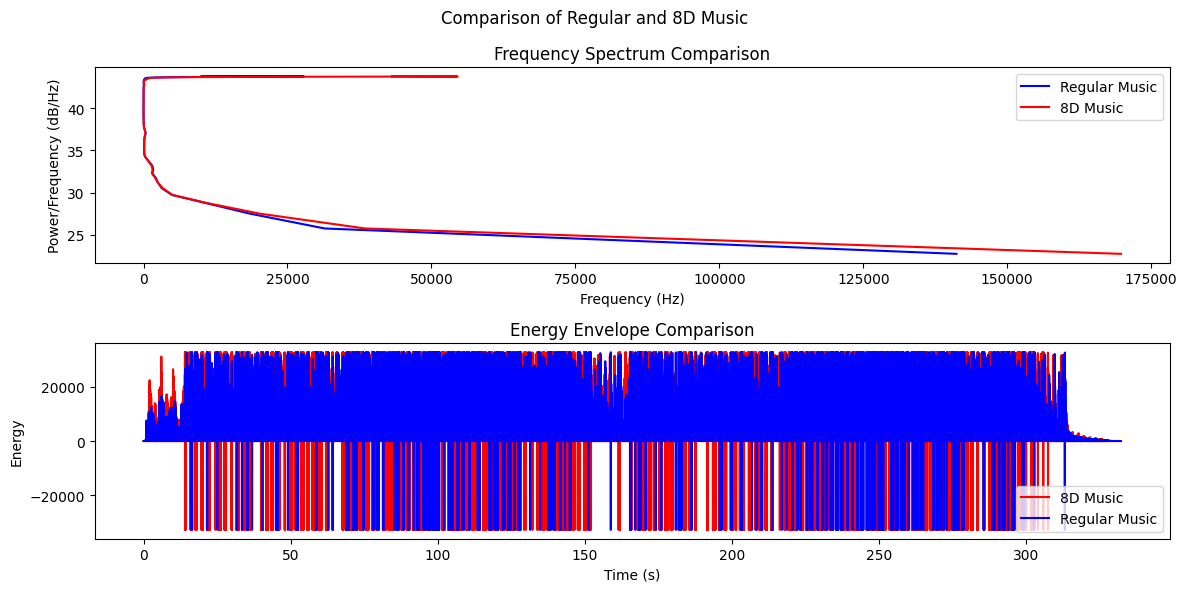

In [ ]:
plot_spectrum_and_envelope(regular_music, music8d, "Comparison of Regular and 8D Music")

In [ ]:
# Function to compute MFCCs from sound data
def compute_mfcc(sound):
    # Convert audio signal to a numpy array with floating-point values for processing
    data = np.array(sound.get_array_of_samples(), dtype=np.float32)

    # Retrieve the sampling rate from the sound object, which is necessary for MFCC calculation
    sample_rate = sound.frame_rate

    # Compute the MFCCs using librosa's feature.mfcc function, which extracts
    # the Mel Frequency Cepstral Coefficients representing the sound
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)

    # Return the computed MFCCs back to the caller
    return mfccs

In [ ]:
# Function to plot MFCCs for comparison
def plot_mfccs(mfccs1, mfccs2, title):
    # Set up the figure size for the plots
    plt.figure(figsize=(10, 6))

    # Plot the MFCCs for the first sound (e.g., regular music)
    # It uses a subplot for multi-part figures - in this case, 2 rows by 1 column, 1st position
    plt.subplot(2, 1, 1)

    # Display the MFCCs as a heatmap using librosa's specshow function
    librosa.display.specshow(mfccs1, x_axis='time')

    # Include a colorbar to indicate the scale
    plt.colorbar()

    # Title for the first MFCC plot (regular music)
    plt.title('MFCCs - Regular Music')

    # Plot the MFCCs for the second sound (e.g., 8D music)
    # Similar layout as the first, but in the 2nd position
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfccs2, x_axis='time')
    plt.colorbar()

    # Title for the second MFCC plot (8D music)
    plt.title('MFCCs - 8D Music')

    # Set an overall title for the combined figure
    plt.suptitle(title)

    # Adjust the layout so everything fits without overlapping
    plt.tight_layout()

    plt.savefig('mfcc.png')  # Or use .jpg, .pdf, etc.


    # Display the plot
    plt.show()

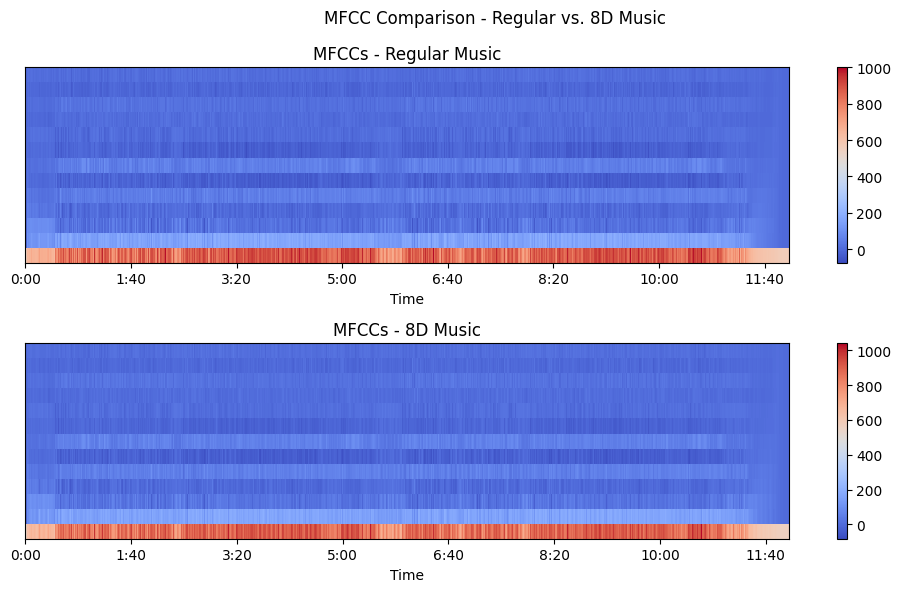

In [ ]:
# Assuming the `regular_music` and `music8d` variables are audio objects that have already been loaded:
# Compute MFCCs for the regular music
mfccs_regular = compute_mfcc(regular_music)

# Compute MFCCs for the 8D music
mfccs_8d = compute_mfcc(music8d)

# Plot the MFCCs for both regular and 8D music for visual comparison
plot_mfccs(mfccs_regular, mfccs_8d, "MFCC Comparison - Regular vs. 8D Music")

In [ ]:
# Function to classify and count the number of MFCCs falling into predefined 'light', 'medium', and 'dark' categories.
def classify_and_count_mfccs(mfccs, thresholds=(0.33, 0.66)):
    """
    Classify MFCC values into light, medium, and dark categories based on defined thresholds,
    and count the number of occurrences in each category.

    :param mfccs: 2D numpy array of MFCCs where rows correspond to time frames and columns to cepstral coefficients.
    :param thresholds: Tuple containing two threshold values to classify the MFCCs.
    :return: Tuple of counts for light, medium, and dark MFCCs.
    """

    # Normalize the MFCC values to a 0-1 range for consistency across different recordings.
    # This is important as different audio tracks may have different ranges of MFCC values.
    mfccs_normalized = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs))

    # Flatten the 2D array of MFCCs to a 1D array for simpler analysis.
    # This treats all MFCC values equally, regardless of their time frame or cepstral coefficient index.
    mfccs_flat = mfccs_normalized.flatten()

    # Count the occurrences of 'light' MFCC values, which are defined as being greater than the upper threshold.
    light_count = np.sum(mfccs_flat > thresholds[1])

    # Count the occurrences of 'medium' MFCC values, which are between the two thresholds.
    medium_count = np.sum((mfccs_flat > thresholds[0]) & (mfccs_flat <= thresholds[1]))

    # Count the occurrences of 'dark' MFCC values, which are less than the lower threshold.
    dark_count = np.sum(mfccs_flat <= thresholds[0])

    # Return the counts for each category.
    return light_count, medium_count, dark_count

In [ ]:
# These data are obtained using librosa's MFCC function on audio samples
light, medium, dark = classify_and_count_mfccs(mfccs_regular)
print(f"Light boxes: {light}, Medium boxes: {medium}, Dark boxes: {dark}")

light, medium, dark = classify_and_count_mfccs(mfccs_8d)
print(f"Light boxes: {light}, Medium boxes: {medium}, Dark boxes: {dark}")

Light boxes: 29561, Medium boxes: 1580, Dark boxes: 373692
Light boxes: 29101, Medium boxes: 1996, Dark boxes: 373164
